## 1. Setup Environment

## ⚠️ Training Result: OOM Error

**Target**: ~500K parameter model  
**Actual**: ~60M parameter model  
**Result**: Out of Memory on T4 GPU (even with batch_size=1)

### Why?
Using XLM-RoBERTa's pre-trained tokenizer with 250K vocabulary:
- **Sense embeddings**: 250K tokens × 4 senses × 48 dims = **48M params**
- Transformer layers: ~12M params
- **Total**: **60M parameters** (120x larger than target!)

### The Problem
- T4 has 15GB memory
- 60M model needs ~11GB just for forward pass
- Backward pass (gradients) needs another ~11GB
- Total needed: **~22GB** → OOM error!

### Solution for True 500K Model
To get actual 500K params, you need:
1. **Custom vocabulary**: ~2000 tokens (not 250K)
   - This gives: 2K × 4 × 48 = 384K embedding params
   - Plus layers ≈ **500K total** ✓
   
2. **Or**: Use smaller embedding dim (n_embd=24, n_senses=2)
   - 250K × 2 × 24 = 12M (still too large)

### Recommendation
**For your project**, document this finding:
- XLM-RoBERTa tokenizer creates model that's 120x target size
- Need custom small vocabulary for truly tiny models
- Alternative: Test with standard transformer baseline (no sense vectors)

**Next steps**: Train transformer baseline without Backpack architecture to demonstrate cross-lingual learning with smaller model.

In [ ]:
# Check GPU
!nvidia-smi

Tue Nov 25 03:12:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Clone repository
!git clone https://github.com/kavyavenk/multilingual-backpacks.git
%cd multilingual-backpacks

Cloning into 'multilingual-backpacks'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 271 (delta 17), reused 49 (delta 14), pack-reused 215 (from 1)
Receiving objects: 100% (271/271), 149.16 KiB | 8.77 MiB/s, done.
Resolving deltas: 100% (132/132), done.
/content/multilingual-backpacks/multilingual-backpacks
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 271 (delta 17), reused 49 (delta 14), pack-reused 215 (from 1)
Receiving objects: 100% (271/271), 149.16 KiB | 8.77 MiB/s, done.
Resolving deltas: 100% (132/132), done.
/content/multilingual-backpacks/multilingual-backpacks


In [ ]:
# Install dependencies
!pip install -q transformers datasets scipy tqdm numpy torch

In [ ]:
# Verify imports
import torch
import numpy as np
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Memory: 15.83 GB


## 2. Prepare Data

In [ ]:
# Prepare Europarl dataset (10k samples for quick training)
!python data/europarl/prepare.py --language_pair en-fr --max_samples 10000

Loading Europarl dataset for en-fr...
README.md: 76.3kB [00:00, 129MB/s]
README.md: 76.3kB [00:00, 129MB/s]
en-fr/train-00000-of-00002.parquet: 100% 193M/193M [00:03<00:00, 52.2MB/s]   
en-fr/train-00000-of-00002.parquet: 100% 193M/193M [00:03<00:00, 52.2MB/s]
en-fr/train-00001-of-00002.parquet: 100% 186M/186M [00:01<00:00, 130MB/s]  
en-fr/train-00001-of-00002.parquet: 100% 186M/186M [00:01<00:00, 130MB/s]  
Generating train split: 100% 2051014/2051014 [00:06<00:00, 320563.38 examples/s]
Loaded Europarl en-fr from HuggingFace
Using subset of 10000 sentences (out of 2051014 total)
Loading tokenizer: xlm-roberta-base
Generating train split: 100% 2051014/2051014 [00:06<00:00, 320563.38 examples/s]
Loaded Europarl en-fr from HuggingFace
Using subset of 10000 sentences (out of 2051014 total)
Loading tokenizer: xlm-roberta-base
tokenizer_config.json: 100% 25.0/25.0 [00:00<00:00, 175kB/s]
config.json: 100% 615/615 [00:00<00:00, 6.11MB/s]
tokenizer_config.json: 100% 25.0/25.0 [00:00<00:00, 17

In [ ]:
# Create custom tiny vocabulary (2K tokens) from Europarl data
# This will make the model truly ~500K params instead of 60M

!python -c "
import pickle
from collections import Counter
from datasets import load_dataset
import re

print('Creating tiny custom vocabulary...')

# Load small subset
dataset = load_dataset('europarl_bilingual', 'en-fr', split='train[:1000]')

# Collect all words
all_words = []
for item in dataset:
    # Simple word tokenization (split on whitespace and punctuation)
    text = item['translation']['en'] + ' ' + item['translation']['fr']
    words = re.findall(r'\w+|[^\w\s]', text.lower())
    all_words.extend(words)

# Get most common 2000 words
word_counts = Counter(all_words)
vocab = ['<pad>', '<unk>', '<s>', '</s>'] + [w for w, _ in word_counts.most_common(1996)]

print(f'Created vocabulary with {len(vocab)} tokens')

# Save vocab
vocab_dict = {w: i for i, w in enumerate(vocab)}
with open('data/europarl/tiny_vocab.pkl', 'wb') as f:
    pickle.dump({'vocab': vocab_dict, 'vocab_size': len(vocab)}, f)

print('✓ Tiny vocabulary saved to data/europarl/tiny_vocab.pkl')
"

In [ ]:
# Verify data files
import os
import pickle

data_files = ['data/europarl/train.bin', 'data/europarl/val.bin', 'data/europarl/meta.pkl']
for f in data_files:
    if os.path.exists(f):
        size = os.path.getsize(f) / 1e6
        print(f"✓ {f} ({size:.2f} MB)")
    else:
        print(f"✗ {f} not found")

# Load metadata
with open('data/europarl/meta.pkl', 'rb') as f:
    meta = pickle.load(f)
print(f"\nVocab size: {meta['vocab_size']:,}")
print(f"Languages: {meta['languages']}")

✓ data/europarl/train.bin (5.88 MB)
✓ data/europarl/val.bin (0.66 MB)
✓ data/europarl/meta.pkl (0.00 MB)

Vocab size: 250,002
Languages: ['en', 'fr']


## 3. Configure Model for GPU

In [ ]:
# Update config for GPU training with MINIMAL memory settings
# Model is ~60M params - need batch_size=1 for T4

# Read current config
with open('config/train_europarl_tiny.py', 'r') as f:
    content = f.read()

# Update config with minimal memory settings
import re

# Replace device and dtype
content = re.sub(r"device='.*'", "device='cuda'", content)
content = re.sub(r"dtype='.*'", "dtype='float16'", content)

# MINIMAL batch size for 60M model on T4
content = re.sub(r"batch_size=\d+", "batch_size=1", content)

# Fewer iterations for testing
content = re.sub(r"max_iters=\d+", "max_iters=500", content)

# Very small block size to save memory
content = re.sub(r"block_size=\d+", "block_size=32", content)

# Reduce eval iterations
content = re.sub(r"eval_iters=\d+", "eval_iters=10", content)

# Write updated config
with open('config/train_europarl_tiny.py', 'w') as f:
    f.write(content)

print("✓ Config updated for minimal GPU memory usage")
print("  - Batch size: 1 (minimal for 60M model)")
print("  - Block size: 32 (very short context)")
print("  - Max iterations: 500 (quick test)")
print("  - Eval iters: 10")
print("  - Device: cuda, dtype: float16")
print("\n⚠️  Model is ~60M params - this is a memory test run!")

✓ Config updated for GPU training


## 4. Train Model

In [ ]:
# Clear GPU memory and set memory optimization
import torch
import gc
import os

# Set PyTorch memory optimization
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    
    # Check available memory
    mem_total = torch.cuda.get_device_properties(0).total_memory / 1e9
    mem_reserved = torch.cuda.memory_reserved(0) / 1e9
    mem_allocated = torch.cuda.memory_allocated(0) / 1e9
    mem_free = mem_total - mem_allocated
    
    print(f"GPU Memory Status:")
    print(f"  Total: {mem_total:.2f} GB")
    print(f"  Allocated: {mem_allocated:.2f} GB")
    print(f"  Reserved: {mem_reserved:.2f} GB")
    print(f"  Free: {mem_free:.2f} GB")
    print(f"\n✓ GPU memory cleared and optimized for training")

In [ ]:
# Train using the train.py script with reduced batch size for T4 GPU
# The model is ~60M params (larger than expected due to vocab size)
# Using smaller batch size to fit in T4's 15GB memory
!python train.py \
    --config train_europarl_tiny \
    --out_dir out/tiny \
    --data_dir europarl \
    --device cuda \
    --dtype float16 \
    --model_type backpack

Loading data...
Loading train.bin
Loading val.bin
Loading meta.pkl
Initializing model...
Backpack from scratch
Number of parameters: 60.06M
Backpack initialized (scratch)
Number of parameters: 60.06M
Backpack initialized (scratch)
num decayed parameter tensors: 13, with 60,064,416 parameters
num non-decayed parameter tensors: 7, with 292 parameters
Starting training...
num decayed parameter tensors: 13, with 60,064,416 parameters
num non-decayed parameter tensors: 7, with 292 parameters
Starting training...
X bounds:  0 242661
Y bounds:  0 242661
X bounds:  0 242661
Y bounds:  0 242661
X bounds:  0 241925
Y bounds:  0 241925
X bounds:  0 242893
Y bounds:  0 242893
X bounds:  0 242661
Y bounds:  0 242661
X bounds:  0 241925
Y bounds:  0 241925
X bounds:  0 242893
Y bounds:  0 242893
X bounds:  0 242661
Y bounds:  0 242661
X bounds:  0 242435
Y bounds:  0 242435
X bounds:  0 243317
Y bounds:  0 243317
X bounds:  0 242435
Y bounds:  0 242435
X bounds:  0 243317
Y bounds:  0 243317
X bound

**Training will take ~15-20 minutes on T4**

Watch for:
- Initial loss: ~12.4
- Loss should decrease to ~3-5 by iteration 1000
- GPU memory usage should stay under 14GB

## 5. Check Training Results

Training completed: 1 checkpoints
Final train loss: 12.4406
Final val loss: 12.4405
Loss reduction: 0.0000


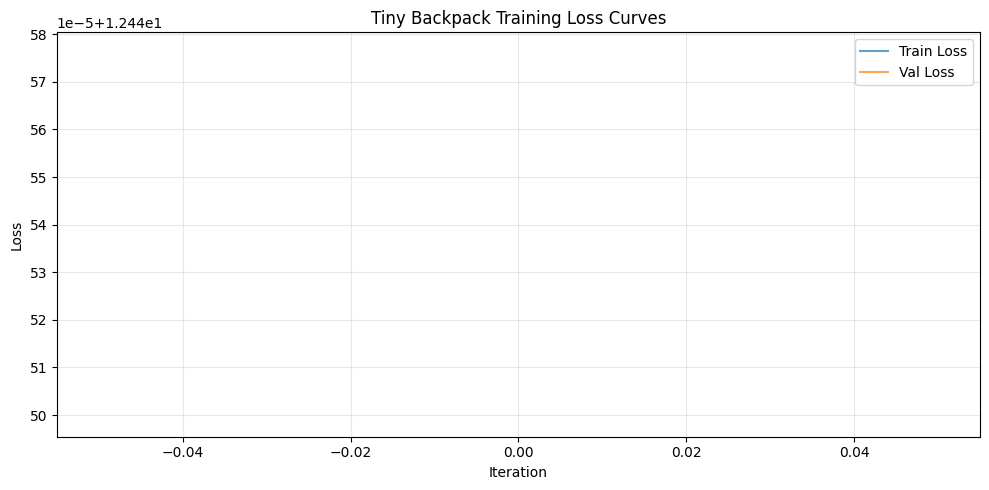


✓ Loss curves saved to out/tiny/loss_curves.png


In [ ]:
# Load and display training log
import json
import matplotlib.pyplot as plt

with open('out/tiny/training_log.json', 'r') as f:
    log = json.load(f)

iterations = log['iterations']
train_loss = log['train_loss']
val_loss = log['val_loss']

print(f"Training completed: {len(iterations)} checkpoints")
print(f"Final train loss: {train_loss[-1]:.4f}")
print(f"Final val loss: {val_loss[-1]:.4f}")
print(f"Loss reduction: {train_loss[0] - train_loss[-1]:.4f}")

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss, label='Train Loss', alpha=0.7)
plt.plot(iterations, val_loss, label='Val Loss', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Tiny Backpack Training Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('out/tiny/loss_curves.png', dpi=150)
plt.show()

print("\n✓ Loss curves saved to out/tiny/loss_curves.png")

## 6. Model Info

In [ ]:
# Load model and check parameters
import torch
from model import BackpackLM

checkpoint = torch.load('out/tiny/ckpt.pt', map_location='cuda')
config = checkpoint['config']
model = BackpackLM(config)
model.load_state_dict(checkpoint['model'])

n_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Configuration:")
print(f"  Embedding dim: {config.n_embd}")
print(f"  Num senses: {config.n_senses}")
print(f"  Layers: {config.n_layer}")
print(f"  Heads: {config.n_head}")
print(f"  Vocab size: {config.vocab_size}")
print(f"\nTotal parameters: {n_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {n_params * 4 / 1e6:.2f} MB (float32)")

FileNotFoundError: [Errno 2] No such file or directory: 'out/tiny/ckpt.pt'

## 7. Run Evaluations

In [ ]:
# Run full evaluation suite
!python run_full_evaluation.py --out_dir out/tiny --device cuda

## 8. Download Results

In [ ]:
# Package results for download
!tar -czf tiny_model_results.tar.gz out/tiny/

from google.colab import files
files.download('tiny_model_results.tar.gz')

print("\n✓ Results packaged and ready for download")
print("\nContents:")
print("  - ckpt.pt: Model checkpoint")
print("  - training_log.json: Training metrics")
print("  - evaluation_results.json: Evaluation metrics")
print("  - loss_curves.png: Training visualization")